In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics as m

from decision_tree import DecisionTree as DecisionTreePython
from decision_tree_numba import DecisionTree as DecisionTreeNumba
import sys

sys.path.append('..')
from utils import plot_multiple_bars

In [2]:
import numpy as np
from numba import njit

In [3]:
iris_dataset = load_iris()
X, y = iris_dataset['data'], iris_dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
%%timeit -r 10 -n 10

model = DecisionTreePython(max_depth=6, min_samples_leaf=1)
model.train(X_train, y_train)

39.8 ms ± 224 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [5]:
model = DecisionTreePython(max_depth=6, min_samples_leaf=1)
model.train(X_train, y_train)

print(m.classification_report(model.predict(X_train), y_train))
print(m.classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        43

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.83      0.91        12
           2       0.71      1.00      0.83         5

    accuracy                           0.93        30
   macro avg       0.90      0.94      0.91        30
weighted avg       0.95      0.93      0.94        30



In [22]:
model = DecisionTreeNumba(max_depth=8, min_samples_leaf=1)
model.train(X_train, y_train)

print(m.classification_report(model.predict(X_train), y_train))
print(m.classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        36

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.89      0.89      0.89         9
           2       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30



In [10]:
%%timeit -r 10 -n 100 -o

model = DecisionTreePython(max_depth=6, min_samples_leaf=1)
model.train(X_train, y_train)

38.4 ms ± 399 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 38.4 ms ± 399 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [11]:
numpy_dt_time = _

In [9]:
%%timeit -r 10 -n 100 -o

model = DecisionTreeNumba(max_depth=6, min_samples_leaf=1)
model.train(X_train, y_train)

1.48 ms ± 28.1 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 1.48 ms ± 28.1 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [8]:
numba_dt_time = _

In [13]:
time_results = {'numpy': numpy_dt_time, 'numba': numba_dt_time,}

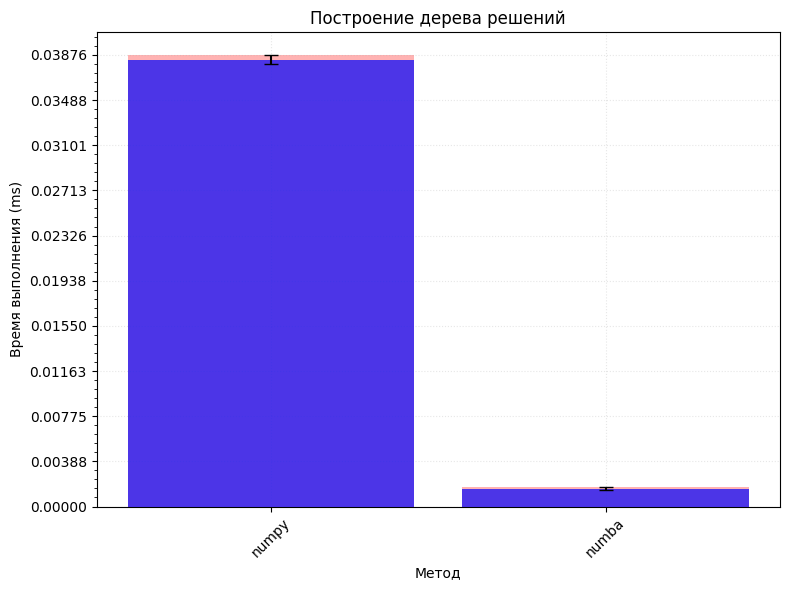

In [15]:
plot_multiple_bars(time_results, title='Построение дерева решений', y_title = 'Время выполнения (ms)')

In [51]:
%%timeit -r 10 -n 10

model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
model.fit(X_train, y_train)

616 μs ± 116 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [46]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
model.fit(X_train[:2], y_train[:2])

DecisionTreeClassifier(max_depth=6)

In [82]:
model = DecisionTreeNumba(max_depth=6, min_samples_leaf=1)

In [84]:
A = np.arange(10)

In [97]:
DecisionTreeNumba._find_best_split_gpu[1, 64](A, A, A, A)

TypeError: Signature mismatch: 4 argument types given, but function takes 3 arguments

In [99]:
DecisionTreeNumba._find_best_split_gpu[1, 64](A, A)

TypeError: Signature mismatch: 2 argument types given, but function takes 3 arguments

In [81]:
model = DecisionTreeNumba(max_depth=6, min_samples_leaf=1)
model.train(X_train[:2], y_train[:2])

(2, 3) (1,) (1, 3)


/home/nikita/projects/tobd_project/.venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypeError: Signature mismatch: 3 argument types given, but function takes 4 arguments

In [80]:
import numpy as np
from numba import cuda, njit


class TreeNode:
    def __init__(
        self, data, feature_idx, feature_val, prediction_probs, information_gain
    ) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:
        if self.left or self.right:
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(
                self.data[:, -1], return_counts=True
            )
            output = ", ".join(
                [
                    f"{value}->{count}"
                    for value, count in zip(unique_values, value_counts)
                ]
            )
            return (
                f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"
            )


class DecisionTreeNumba:
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(
        self,
        max_depth: int = 4,
        min_samples_leaf: int = 1,
        min_information_gain: float = 0.0,
        numb_of_features_splitting: str = None,
    ) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(
                                                            if log then log(
                                                            else all features are considered
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting

    @staticmethod
    @njit
    def _entropy(class_probabilities: np.ndarray) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p > 0])

    @staticmethod
    @njit
    def _find_label_probs(data: np.array, labels_in_train: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(np.int32)
        total_labels = len(labels_as_integers)
        label_probabilities = np.zeros(len(labels_in_train), dtype=float)

        for i in range(len(labels_in_train)):
            count = 0
            for j in range(total_labels):
                if labels_as_integers[j] == i:
                    count += 1
            label_probabilities[i] = count / total_labels

        return label_probabilities

    @staticmethod
    @cuda.jit
    def _find_best_split_gpu(data, feature_idx, results):
        """
        Kernel function to find the best split on GPU
        """
        idx = cuda.grid(1)
        if idx < feature_idx.size:
            feature_vals = np.percentile(data[:, feature_idx[idx]], q=np.arange(25, 100, 25))
            min_part_entropy = 1e9
            min_entropy_feature_idx = -1
            min_entropy_feature_val = -1
            g1_min, g2_min = None, None

            for feature_val in feature_vals:
                mask_below_threshold = data[:, feature_idx[idx]] < feature_val
                g1 = data[mask_below_threshold]
                g2 = data[~mask_below_threshold]

                subsets = [g1[:, -1], g2[:, -1]]
                total_count = sum([len(subset) for subset in subsets])
                part_entropy = 0.0
                for subset in subsets:
                    total_count_subset = len(subset)
                    unique_values = np.unique(subset)
                    class_probabilities = np.zeros(shape=unique_values.shape)

                    for i, value in enumerate(unique_values):
                        class_probabilities[i] = (
                            np.sum(subset == value) / total_count_subset
                        )

                    subset_entropy = 0.0
                    for p in class_probabilities:
                        if p > 0:
                            subset_entropy -= p * np.log2(p)

                    part_entropy += subset_entropy * (total_count_subset / total_count)

                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = feature_idx[idx]
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

            results[idx, 0] = min_entropy_feature_idx
            results[idx, 1] = min_entropy_feature_val
            results[idx, 2] = min_part_entropy

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        if current_depth > self.max_depth:
            return None

        feature_idx = np.arange(data.shape[1] - 1)
        feature_idx_to_use = np.random.choice(
            feature_idx, size=int(np.sqrt(len(feature_idx)))
        )

        # Allocate device memory for results
        results = cuda.device_array((len(feature_idx_to_use), 3), dtype=np.float32)
        threads_per_block = 64
        blocks_per_grid = (len(feature_idx_to_use) + (threads_per_block - 1)) // threads_per_block

        # Launch kernel to find best split
        print(data.shape, feature_idx_to_use.shape, results.shape)
        self._find_best_split_gpu[blocks_per_grid, threads_per_block](data, feature_idx_to_use, results)

        # Get the results back to host
        results_host = results.copy_to_host()

        min_entropy_feature_idx = int(results_host[:, 0].argmin())
        min_entropy_feature_val = results_host[min_entropy_feature_idx, 1]
        min_part_entropy = results_host[min_entropy_feature_idx, 2]

        # Apply the best split to the data
        mask_below_threshold = data[:, min_entropy_feature_idx] < min_entropy_feature_val
        g1 = data[mask_below_threshold]
        g2 = data[~mask_below_threshold]

        label_probabilities = self._find_label_probs(data, self.labels_in_train)

        node_entropy = self._entropy(np.array(label_probabilities))
        information_gain = node_entropy - min_part_entropy

        node = TreeNode(
            data,
            min_entropy_feature_idx,
            min_entropy_feature_val,
            label_probabilities,
            information_gain,
        )

        if (
            self.min_samples_leaf > g1.shape[0]
            or self.min_samples_leaf > g2.shape[0]
        ):
            return node

        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(g1, current_depth)
        node.right = self._create_tree(g2, current_depth)

        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        self.tree = self._create_tree(data=train_data, current_depth=0)

        self.feature_importances = dict.fromkeys(range(X_train.shape[1]))
        for node in self.tree:
            self.feature_importances[node.feature_idx] += node.feature_importance

    def predict(self, X_test: np.array) -> np.array:
        """
        Predicts output for given X_test data
        """
        predictions = np.zeros((X_test.shape[0], len(self.labels_in_train)))
        for idx, x in enumerate(X_test):
            pred_probs = self._predict_one_sample(x)
            predictions[idx, :] = pred_probs

        return predictions


In [41]:
import numpy as np
from collections import Counter
from numba import njit


class TreeNode:
    def __init__(
        self, data, feature_idx, feature_val, prediction_probs, information_gain
    ) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:
        if self.left or self.right:
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(
                self.data[:, -1], return_counts=True
            )
            output = ", ".join(
                [
                    f"{value}->{count}"
                    for value, count in zip(unique_values, value_counts)
                ]
            )
            return (
                f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"
            )


class DecisionTreeNumba:
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(
        self,
        max_depth: int = 4,
        min_samples_leaf: int = 1,
        min_information_gain: float = 0.0,
        numb_of_features_splitting: str = None,
    ) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered,
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting

    @staticmethod
    @njit
    def _entropy(class_probabilities: np.ndarray) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])
    
    @staticmethod
    @njit
    def _find_label_probs(data: np.array, labels_in_train: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(np.int32)
        total_labels = len(labels_as_integers)
        label_probabilities = np.zeros(len(labels_in_train), dtype=float)

        # Calculate the frequency of each label in the dataset
        for i in range(len(labels_in_train)):
            count = 0
            for j in range(total_labels):
                if labels_as_integers[j] == i:
                    count += 1
            label_probabilities[i] = count / total_labels

        return label_probabilities

    @staticmethod
    @njit
    def _find_best_split(data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9

        feature_idx = np.arange(data.shape[1] - 1)
        feature_idx_to_use = np.random.choice(
            feature_idx, size=int(np.sqrt(len(feature_idx)))
        )

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                mask_below_threshold = data[:, idx] < feature_val
                g1 = data[mask_below_threshold]
                g2 = data[~mask_below_threshold]
                subsets = [g1[:, -1], g2[:, -1]]
                total_count = sum([len(subset) for subset in subsets])
                part_entropy = 0.0
                for subset in subsets:
                    total_count_subset = len(subset)
                    unique_values = np.unique(subset)
                    class_probabilities = np.zeros(shape=unique_values.shape)

                    for i, value in enumerate(unique_values):
                        class_probabilities[i] = np.sum(subset == value) / total_count_subset

                    subset_entropy = 0.0
                    for p in class_probabilities:
                        if p > 0:
                            subset_entropy -= p * np.log2(p)
                    
                    part_entropy += subset_entropy * (total_count_subset / total_count)

                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return (
            g1_min,
            g2_min,
            min_entropy_feature_idx,
            min_entropy_feature_val,
            min_part_entropy,
        )

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None

        # Find best split
        (
            split_1_data,
            split_2_data,
            split_feature_idx,
            split_feature_val,
            split_entropy,
        ) = self._find_best_split(data)

        # Find label probs for the node
        label_probabilities = self._find_label_probs(data, self.labels_in_train)

        # Calculate information gain
        node_entropy = self._entropy(np.array(label_probabilities))
        information_gain = node_entropy - split_entropy

        # Create node
        node = TreeNode(
            data,
            split_feature_idx,
            split_feature_val,
            label_probabilities,
            information_gain,
        )

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if (
            self.min_samples_leaf > split_1_data.shape[0]
            or self.min_samples_leaf > split_2_data.shape[0]
        ):
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)

        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {
            k: v / total
            for total in (sum(self.feature_importances.values()),)
            for k, v in self.feature_importances.items()
        }

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)

        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)

        return preds

    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print("    " * 4 * level + "-> " + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)